# Biological Models

Implement the biological based RL model variants.

```
author:    Zach Wolpe
email:     zachcolinwolpe@gmail.com
date:      22 January 2022
```


# ETL

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import arviz as az
import pystan
import pickle
import math

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [ ]:
path            = '/content/df_wcst_ran_100.csv'
path2           = '/content/df_wcst_top_100.csv'
df_wcst_ran_100 = pd.read_csv(path)
wcst_top_100    = pd.read_csv(path2)

# Transform Data

In [ ]:

def pystan_transform_dataset(wcst_subset):
  wcst_subset.action   = wcst_subset.action.astype(int)
  wcst_subset.reward   = wcst_subset.reward.astype(int)
  action_matrix = wcst_subset[['participant' ,'n_t', 'action']].pivot(index='participant', columns='n_t')
  reward_matrix = wcst_subset[['participant' ,'n_t', 'reward']].pivot(index='participant', columns='n_t')
  data_object = {
      'n_s':    reward_matrix.shape[0],
      'n_t':    reward_matrix.shape[1],
      'action': action_matrix,
      'reward': reward_matrix+1
  }
  return data_object


data_object_top = pystan_transform_dataset(wcst_top_100)
data_object_ran = pystan_transform_dataset(df_wcst_ran_100)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Save object

In [ ]:
def save_model_object(name, model, fit, data_object):
  stan_object = {'name': name, 'model': model, 'fit':fit, 'data_object':data_object}  # create object
  loo, loos, ks = psisloo(fit['log_lik'])                                             # likehilood statistics
  with open(name + ".pkl", "wb") as f:
    pickle.dump(stan_object, f, protocol=-1)
  print('Successfully saved: ' + name + ".pkl")

# Null Model

In [ ]:
null_model = """

data {
  int<lower=1>  n_s;
  int<lower=1>  n_t;
  int           action[n_s, n_t];     
  int           reward[n_s, n_t]; 
}

transformed data {
  vector[3] initQs; 
  initQs    = rep_vector(0.3333, 3);
}

parameters {
  // raw parameters: reparameterization trick
  real          a_mu_raw;
  real          b_mu_raw;
  real<lower=0> a_sd_raw;
  real<lower=0> b_sd_raw;
  vector[n_s]   a_raw;
  vector[n_s]   b_raw;
}

transformed parameters {
  vector<lower=0, upper=1>[n_s]   a;
  vector<lower=0, upper=10>[n_s]  b;

  for (s in 1:n_s) {
    a[s] = Phi_approx(a_mu_raw + a_sd_raw * a_raw[s]);
    b[s] = Phi_approx(b_mu_raw + b_sd_raw * b_raw[s]) * 10;
  }
  
}

model {

  a_mu_raw  ~ normal(0,1);
  b_mu_raw  ~ normal(0,1);
  a_sd_raw  ~ cauchy(0,3);
  b_sd_raw  ~ cauchy(0,3);
  a_raw     ~ normal(0,1);
  b_raw     ~ normal(0,1);
  
  
  for (s in 1:n_s) {
    vector[3] Qs; 
    real      pe;    
    Qs        = initQs;

    for (t in 1:n_t) {        
      action[s,t]     ~ categorical_logit( b[s] * Qs);
      pe              = reward[s,t] - 1 - Qs[action[s,t]];      
      Qs[action[s,t]] = Qs[action[s,t]] + a[s] * pe; 
    }
  }    
}


generated quantities {
  real<lower=0, upper=1>  a_mu;
  real<lower=0, upper=10> b_mu;
  real                    log_lik[n_s];

  //real<lower=0, upper=10> a_sd;
  //real<lower=0, upper=10> b_sd;

  // recover 
  a_mu = Phi_approx(a_mu_raw);
  b_mu = Phi_approx(b_mu_raw) * 10;

  //a_sd = Phi_approx(a_sd_raw) * 10;
  //b_sd = Phi_approx(b_sd_raw) * 10;



  // log-likelihood
  //real  log_lik[n_s];

  { // local section, this saves time and space
     for (s in 1:n_s) {
       vector[3]  Qs; 
       real       pe;    

       log_lik[s] = 0;
       Qs         = initQs;

       for (t in 1:n_t) {    
         log_lik[s]       = log_lik[s] + categorical_logit_lpmf(action[s,t] | b[s] * Qs);        
         pe               = reward[s,t] - 1 - Qs[action[s,t]];      
         Qs[action[s,t]]  = Qs[action[s,t]] + a[s] * pe; 
       }
     }    
   }
}




"""

In [ ]:
# Null model: top 100
null_model_top = pystan.stan(model_code=null_model, warmup=1000, data=data_object_top, iter=2000, chains=2) # control=dict(adapt_delta=0.9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7b09ca97f1f09a52c5d62f1194b11d4 NOW.


In [ ]:
save_model_object(name='null_model_top100', model=null_model, fit=null_model_top, data_object=data_object_top)

Successfully saved: null_model_top100.pkl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


In [ ]:
print(null_model_top)

Inference for Stan model: anon_model_f7b09ca97f1f09a52c5d62f1194b11d4.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

               mean se_mean     sd   2.5%     25%     50%     75%  97.5%  n_eff   Rhat
a_mu_raw       1.56  5.7e-3   0.18   1.27    1.43    1.55    1.66    2.0    993    1.0
b_mu_raw       0.12  1.3e-3   0.04   0.04    0.09    0.12    0.15    0.2   1096    1.0
a_sd_raw       0.87  5.6e-3   0.15   0.62    0.76    0.85    0.95   1.21    732    1.0
b_sd_raw       0.27  1.3e-3   0.04    0.2    0.24    0.26    0.29   0.35    900    1.0
a_raw[1]       0.71    0.01   0.71  -0.52     0.2    0.64     1.2   2.22   3572    1.0
a_raw[2]      -0.58    0.02   0.75   -1.6    -1.1   -0.73   -0.22   1.37   1195    1.0
a_raw[3]       0.46    0.01   0.74  -0.78   -0.06     0.4    0.92    2.0   2457    1.0
a_raw[4]       0.23    0.02   0.81  -1.11   -0.35    0.14    0.73   2.06   2439    1.0
a_raw[5]      -0.05    0.02 

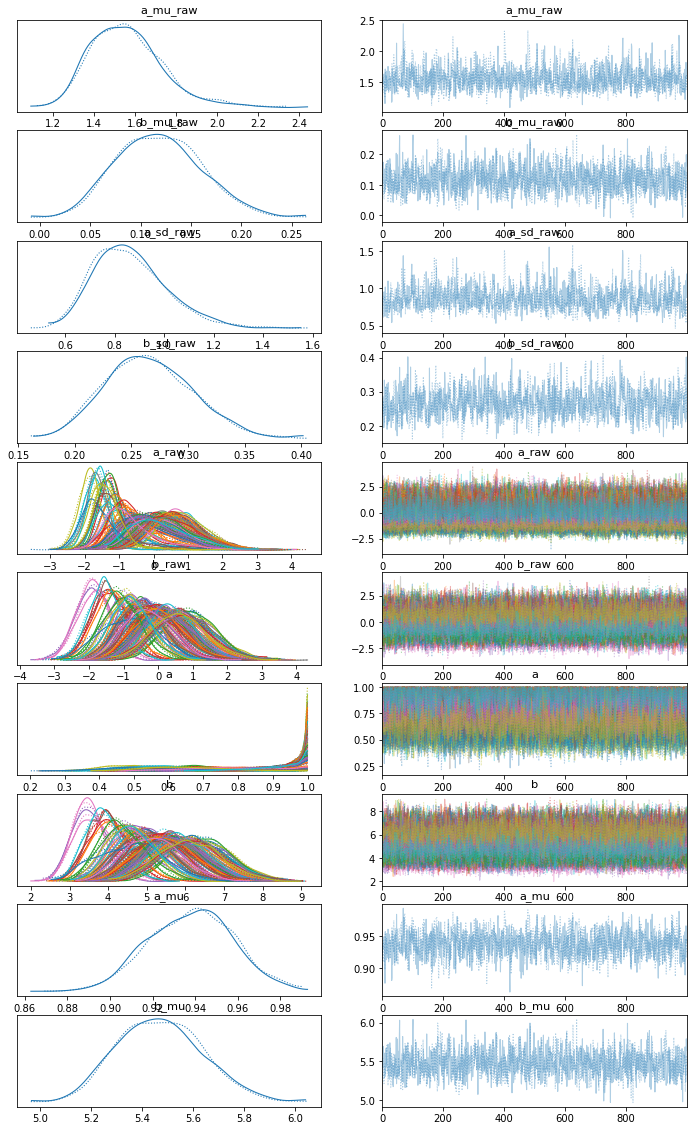

In [ ]:
az.plot_trace(null_model_top);

In [ ]:
# Null model: rand 100
null_model_ran = pystan.stan(model_code=null_model, warmup=1000, data=data_object_ran, iter=2000, chains=2) # control=dict(adapt_delta=0.9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f7b09ca97f1f09a52c5d62f1194b11d4 NOW.


In [ ]:
save_model_object(name='null_model_ran100', model=null_model, fit=null_model_ran, data_object=data_object_ran)

Successfully saved: null_model_ran100.pkl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


In [26]:
print(null_model_ran)

Inference for Stan model: anon_model_f7b09ca97f1f09a52c5d62f1194b11d4.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a_mu_raw       1.29  9.7e-3   0.24   0.87   1.12   1.27   1.44   1.81    616    1.0
b_mu_raw       0.08  1.8e-3   0.05  -0.02   0.04   0.07   0.11   0.18    905    1.0
a_sd_raw        1.7    0.01   0.24    1.3   1.53   1.67   1.84   2.23    381    1.0
b_sd_raw       0.45  1.9e-3   0.05   0.36   0.41   0.45   0.48   0.55    711    1.0
a_raw[1]       0.73    0.02   0.67  -0.27   0.24   0.62    1.1   2.22   1825    1.0
a_raw[2]       0.57    0.02   0.65   -0.4   0.09   0.45   0.95   2.05   1866    1.0
a_raw[3]        0.8    0.01   0.61  -0.11   0.35    0.7   1.18    2.2   2070    1.0
a_raw[4]       0.56    0.02   0.65  -0.37   0.07   0.43   0.96   2.12   1128    1.0
a_raw[5]       0.37    0.02   0.65  -0.51  -0.11   0.23

In [ ]:
loo, loos, ks = psisloo(null_model_top['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -2742.02


In [ ]:
loo, loos, ks = psisloo(null_model_ran['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -4111.41


In [ ]:
# Store
extr = null_model_top.extract()
np.savez('./null_model_top.npz', extr)
extr = null_model_ran.extract()
np.savez('./null_model_ran.npz', extr)

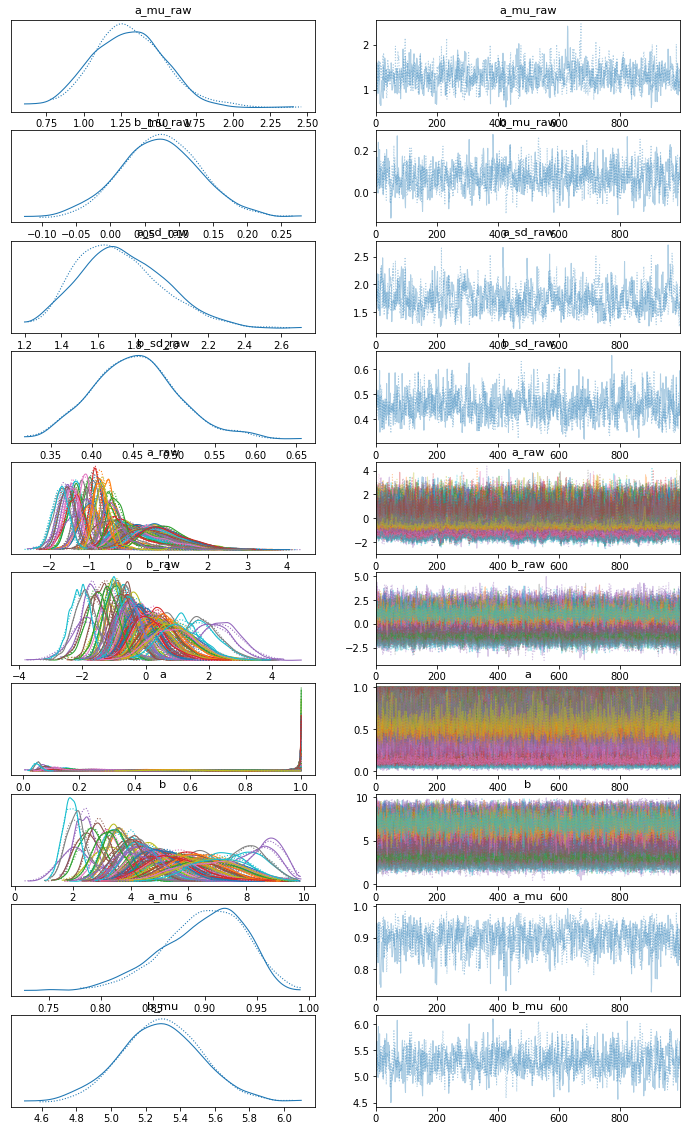

In [ ]:
az.plot_trace(null_model_ran);

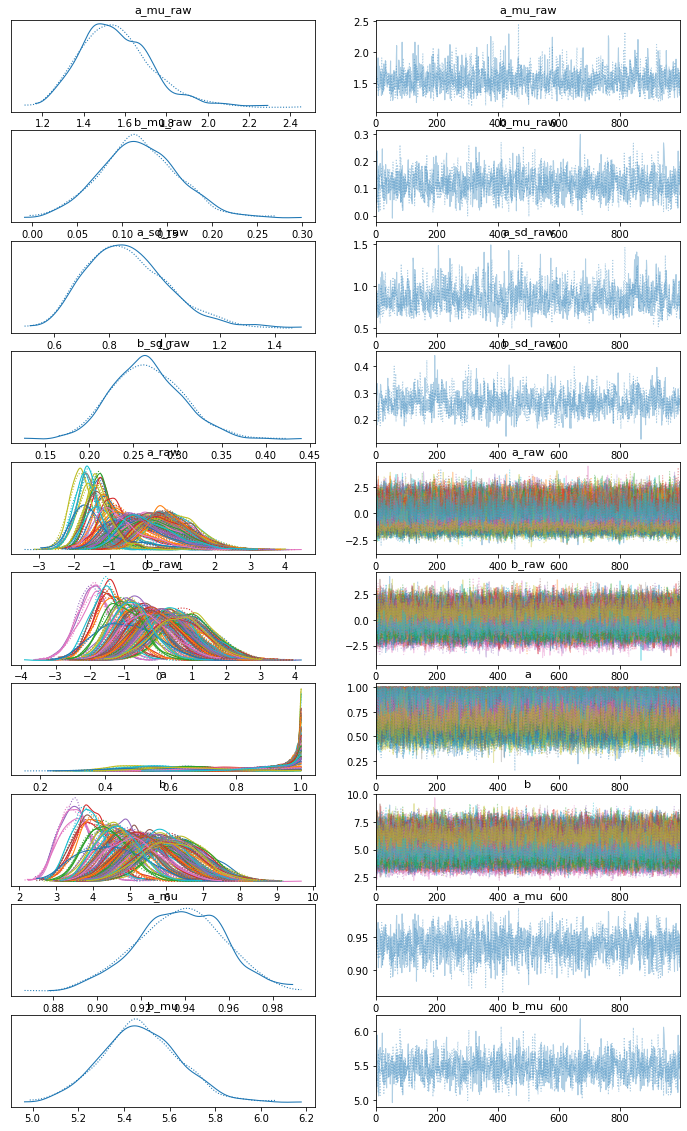

In [ ]:
az.plot_trace(null_model_top);

In [ ]:
mod = np.load('./null_model_top.npz', allow_pickle=True)

sorted(mod.files)

['arr_0']

(array([  5.,  20.,  91., 201., 378., 475., 449., 254.,  99.,  28.]),
 array([0.86693987, 0.87955037, 0.89216088, 0.90477138, 0.91738189,
        0.9299924 , 0.9426029 , 0.95521341, 0.96782391, 0.98043442,
        0.99304492]),
 <a list of 10 Patch objects>)

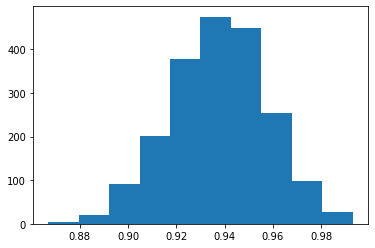

In [ ]:

a_mu = mod['arr_0'].tolist()['a_mu']# .keys()

plt.hist(a_mu)

# Bio-Model 1: Two learning Rates

$\alpha \in \{\alpha_g, \alpha_l\}$

$Rt: {1,2}$


In [ ]:
bio_model_1 = """

data {
  int<lower=1>  n_s;
  int<lower=1>  n_t;
  int           action[n_s, n_t];     
  int           reward[n_s, n_t]; 
}

transformed data {
  vector[3] initQs;
  initQs    = rep_vector(0.3333, 3);
}

parameters {
  // raw parameters
  real          ag_mu_raw;
  real          al_mu_raw;
  real          b_mu_raw;
  real<lower=0> ag_sd_raw;
  real<lower=0> al_sd_raw;
  real<lower=0> b_sd_raw;

  vector[n_s] ag_raw;
  vector[n_s] al_raw;
  vector[n_s] b_raw;
}

transformed parameters {
  vector<lower=0, upper=1>[n_s]   ag;
  vector<lower=0, upper=1>[n_s]   al;
  vector<lower=0, upper=10>[n_s]  b;


  for (s in 1:n_s) {
    ag[s] = Phi_approx(ag_mu_raw  + ag_sd_raw * ag_raw[s]);
    al[s] = Phi_approx(al_mu_raw  + al_sd_raw * al_raw[s]);
    b[s]  = Phi_approx(b_mu_raw   + b_sd_raw  * b_raw[s]) * 10;
  }
}



model {

  ag_mu_raw   ~ normal(0,1);
  al_mu_raw   ~ normal(0,1);
  b_mu_raw    ~ normal(0,1);
  ag_sd_raw   ~ cauchy(0,3);
  al_sd_raw   ~ cauchy(0,3);
  b_sd_raw    ~ cauchy(0,3);

  ag_raw      ~ normal(0,1);
  al_raw      ~ normal(0,1);
  b_raw       ~ normal(0,1);
  
  
  for (s in 1:n_s) {
    vector[3] Qs; 
    real pe;    
    Qs = initQs;

    for (t in 1:n_t) {        
      action[s,t] ~ categorical_logit( b[s] * Qs);
      pe = reward[s,t] - 1 - Qs[action[s,t]];
      if (reward[s,t] == 2) {
        // correct
        Qs[action[s,t]] = Qs[action[s,t]] + ag[s] * pe;
      }
      if (reward[s,t] == 1) {
        // incorrect
        Qs[action[s,t]] = Qs[action[s,t]] + al[s] * pe;
      }
      
    }
  }    
}



generated quantities {
  real<lower=0, upper=1> ag_mu;
  real<lower=0, upper=1> al_mu;
  real<lower=0, upper=10> b_mu;
  real  log_lik[n_s];

  // recover 
  ag_mu = Phi_approx(ag_mu_raw);
  al_mu = Phi_approx(al_mu_raw);
  b_mu = Phi_approx(b_mu_raw) * 10;


  // log-likelihood
  //real  log_lik[n_s];

  { // local section, this saves time and space
     for (s in 1:n_s) {
       vector[3] Qs; 
       real pe;    

       log_lik[s] = 0;
       Qs         = initQs;

       for (t in 1:n_t) {    
         log_lik[s] = log_lik[s] + categorical_logit_lpmf(action[s,t] | b[s] * Qs);    
              
         pe = reward[s,t] - 1 - Qs[action[s,t]];

         if (reward[s,t] == 2) {
           Qs[action[s,t]] = Qs[action[s,t]] + ag[s] * pe; 
         }
         if (reward[s,t] == 1) {
           Qs[action[s,t]] = Qs[action[s,t]] + al[s] * pe; 
         }
       }
     }    
   }
}

"""

In [ ]:
bio_model_1_top = pystan.stan(model_code=bio_model_1, warmup=1000, data=data_object_top, iter=2000, chains=2) # control=dict(adapt_delta=0.9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_187e0bfa2fe4400847a9b13e0308d315 NOW.


In [ ]:
save_model_object(name='bio_model_1_top100', model=bio_model_1, fit=bio_model_1_top, data_object=data_object_top)

Successfully saved: bio_model_1_top100.pkl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


In [ ]:
bio_model_1_ran = pystan.stan(model_code=bio_model_1, warmup=1000, data=data_object_ran, iter=2000, chains=2) # control=dict(adapt_delta=0.9)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_187e0bfa2fe4400847a9b13e0308d315 NOW.


In [ ]:
save_model_object(name='bio_model_1_ran100', model=bio_model_1, fit=bio_model_1_ran, data_object=data_object_ran)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


Successfully saved: bio_model_1_ran100.pkl


In [ ]:
loo, loos, ks = psisloo(bio_model_1_top['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -2683.73


In [ ]:
loo, loos, ks = psisloo(bio_model_1_ran['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -3985.24


# Bio-model 2: Action Bias Model

In [ ]:
bio_model_2 = """

data {
  int<lower=1> n_s;
  int<lower=1> n_t;
  int action[n_s, n_t];     
  int reward[n_s, n_t]; 
}

transformed data {
  vector[3] initQs;
  initQs = rep_vector(0.3333, 3);
}



parameters {
  real a_mu_raw;
  real b_mu_raw;
  real<lower=0> a_sd_raw;
  real<lower=0> b_sd_raw;


  //vector[n_s] ag_raw;
  //vector[n_s] al_raw;
  vector[n_s] a_raw;
  vector[n_s] b_raw;


  // bias nodes

  // bias: population params
  real bias_mu_raw;
  real<lower=0> bias_sd_raw;

  // bias: subject params
  matrix[n_s, 3] bias_raw;

}

transformed parameters {
  vector<lower=0, upper=1>[n_s] a;
  vector<lower=0, upper=10>[n_s] b;
  matrix<lower=0, upper=10>[n_s, 3] bias;


  for (s in 1:n_s) {
    a[s] = Phi_approx(a_mu_raw + a_sd_raw * a_raw[s]);
    b[s] = Phi_approx(b_mu_raw +  b_sd_raw * b_raw[s]) * 10;
    for (i in 1:3) {
      bias[s, i] = Phi_approx(bias_mu_raw + bias_sd_raw) * 10;
    }
  }
  
}

model {

  a_mu_raw   ~ normal(0,1);
  b_mu_raw    ~ normal(0,1);
  a_sd_raw   ~ cauchy(0,3);
  b_sd_raw    ~ cauchy(0,3);
  a_raw      ~ normal(0,1);
  b_raw       ~ normal(0,1);


  // bias: population params
  bias_mu_raw ~ normal(0,1);
  bias_sd_raw ~ cauchy(0,3);

  // bias: subject params *******
  to_vector(bias_raw)    ~ normal(0,1);


  
  for (s in 1:n_s) {
    vector[3] Qs; 
    real pe;    
    Qs = initQs;

    for (t in 1:n_t) {        
      action[s,t] ~ categorical_logit( b[s] * Qs);
      pe = reward[s,t] - 1 - Qs[action[s,t]];      

      // add bias to update equation
      Qs[action[s,t]] = Qs[action[s,t]] + a[s] * pe + bias[s, action[s,t]]; 
    }
  }    
}



generated quantities {
  real<lower=0, upper=1> a_mu;
  //real<lower=0, upper=1> al_mu;
  real<lower=0, upper=10> b_mu;
  real  log_lik[n_s];

  real<lower=0, upper=10> bias_mu;

  // recover 
  a_mu = Phi_approx(a_mu_raw);
  //al_mu = Phi_approx(al_mu_raw);
  b_mu = Phi_approx(b_mu_raw) * 10;



  


  // recover bias
  bias_mu = Phi_approx(bias_mu_raw) * 10; 


  // log-likelihood
  //real  log_lik[n_s];

  { // local section, this saves time and space
     for (s in 1:n_s) {
       vector[3] Qs; 
       real pe;    

       log_lik[s] = 0;
       Qs = initQs;

       for (t in 1:n_t) {    
         log_lik[s] = log_lik[s] + categorical_logit_lpmf(action[s,t] | b[s] * Qs);    
              
         pe = reward[s,t] - 1 - Qs[action[s,t]];  
         Qs[action[s,t]] = Qs[action[s,t]] + a[s] * pe + bias[s, action[s,t]];
       }
     }    
   }
}


"""

In [ ]:
bio_model_2_top = pystan.stan(model_code=bio_model_2, warmup=1000, data=data_object_top, iter=2000, chains=2,  control=dict(adapt_delta=0.9))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2aede3e91ed347f32559b0bc421fb323 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
save_model_object(name='bio_model_2_top100', model=bio_model_2, fit=bio_model_2_top, data_object=data_object_top)

Successfully saved: bio_model_2_top100.pkl


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


In [ ]:
loo, loos, ks = psisloo(bio_model_2_top['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -2676.91


In [ ]:
bio_model_2_ran = pystan.stan(model_code=bio_model_2, warmup=1000, data=data_object_ran, iter=2000, chains=2,  control=dict(adapt_delta=0.9))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33ea7a08e3296c1e3aafc6c6cfc197f6 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
save_model_object(name='bio_model_2_ran100', model=bio_model_2, fit=bio_model_2_ran, data_object=data_object_ran)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  """


Successfully saved: bio_model_2_ran100.pkl


In [ ]:
loo, loos, ks = psisloo(bio_model_2_ran['log_lik'])
print('PSIS-LOO value: {:.2f}'.format(loo))

PSIS-LOO value: -4038.23


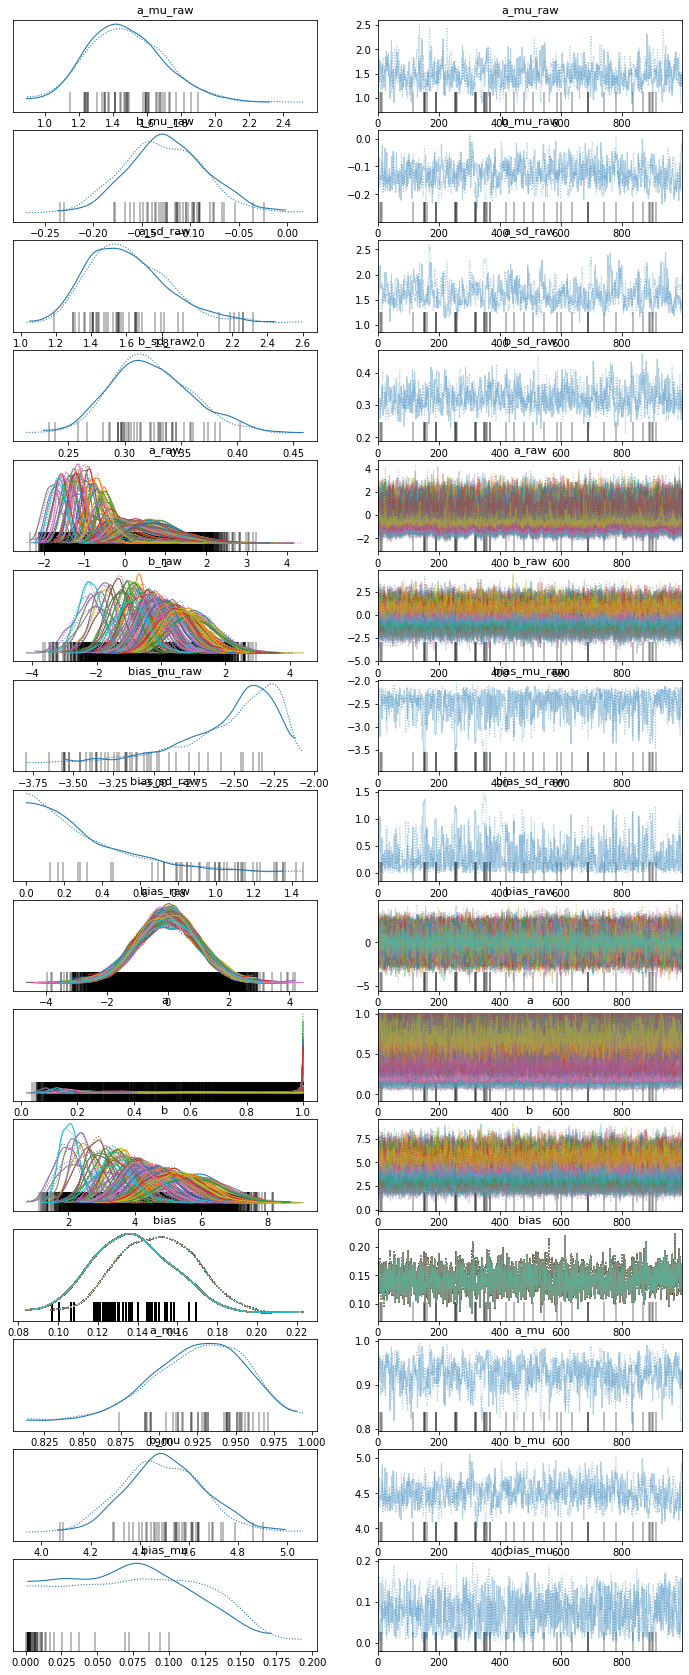

In [ ]:
az.plot_trace(bio_model_2_ran);

2.459462506821313

PSIS-LOO value: -2683.02


# Supporting Package

[package url](https://github.com/avehtari/PSIS)


In [ ]:
"""Pareto smoothed importance sampling (PSIS)
This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).
Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.
psislw
    Pareto smoothed importance sampling.
gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).
gpinv
    Inverse Generalised Pareto distribution function.
sumlogs
    Sum of vector where numbers are represented by their logarithms.
References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5
"""

from __future__ import division # For Python 2 compatibility
import numpy as np

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula
Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out